# Script to analyze microbiome abundance data

This script takes as starting point the curated metagenomics dataset from the Waldron lab: https://waldronlab.io/curatedMetagenomicData/index.html



In [1]:
#load required packages
import pandas as pd
import subprocess
import numpy as np
import json
import os, sys

#from fipy import *
from datetime import datetime
import numpy as np
import json
import time
from matplotlib import rc_file
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from pylab import *


# Load curated microbiome data

The original data is provided in R. Here, we use only the abundance data, provided in easily to handle csv files (subfolder data_curated_microbiome). The abundance levels were extracted from metagenomics using https://github.com/biobakery/MetaPhlAn.


In [3]:
#big table with abundance of different species in all thausands of samples from the data collection
relab=pd.read_csv("data_curated_microbiome/relabundance.csv")
relab.rename(columns={'Unnamed: 0': 'tax_identifier'},inplace=True)
display(relab.head(3))
display(relab.shape)

#information about samples
colnames=pd.read_csv("data_curated_microbiome/relabundance_colData.csv")
colnames.rename(columns={'Unnamed: 0': 'sample'},inplace=True)
display(colnames.head(3))
display(colnames.shape)

#information about different species detected in the different samples
rownames=pd.read_csv("data_curated_microbiome/relabundance_rowData.csv")
rownames.rename(columns={'Unnamed: 0': 'tax_identifier'},inplace=True)
display(rownames.head(3))
display(rownames.shape)

#add species information to major data table. Used for groupby analysis later on
relab2 = relab.merge(rownames, on='tax_identifier', how='inner')
display(relab2.head(3))

,tax_identifier,MV_FEI1_t1Q14,MV_FEI2_t1Q14,MV_FEI3_t1Q14,MV_FEI4_t1Q14,MV_FEI4_t2Q15,MV_FEI5_t1Q14,MV_FEI5_t2Q14,MV_FEI5_t3Q15,MV_FEM1_t1Q14,...,wHAXPI034926-15,wHAXPI037144-8,wHAXPI037145-9,wHAXPI037146-11,wHAXPI037147-12,wHAXPI043592-8,wHAXPI043593-9,wHAXPI043594-11,wHAXPI047830-11,wHAXPI048670-90
0,Escherichia coli,59.35010,0.00000,85.42333,46.70438,0.54770,0.0,0.02243,0.00000,0.00000,...,0.02811,0.41802,3.13657,1.26867,2.79116,0.07465,0.10713,0.40001,0.45324,6.05846
1,Bifidobacterium bifidum,16.16243,5.61882,0.20192,0.00000,26.63938,0.0,0.00000,19.20307,0.13643,...,0.00000,0.00000,0.00000,2.37212,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Bifidobacterium longum,7.79189,60.54102,0.49524,0.00000,0.00000,0.0,0.00000,28.51001,0.05094,...,0.33410,0.39197,0.09752,3.19180,0.18976,0.00330,0.55654,0.69706,2.61017,0.03886


(1627, 18726)

/var/folders/4b/8dffvbfs5qs93rh77f2zxs340000gn/T/ipykernel_7943/4071166616.py:8: DtypeWarning: Columns (21,22,27,29,30,33,36,43,50,52,53,54,55,56,57,62,63,70,72,76,77,87,90,98,99,102,106,107,108,109,111,114,115,116,123) have mixed types. Specify dtype option on import or set low_memory=False.
  colnames=pd.read_csv("data_curated_microbiome/relabundance_colData.csv")


,sample,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age,infant_age,age_category,...,hla_drb11,birth_order,age_twins_started_to_live_apart,zigosity,brinkman_index,alcohol_numeric,breastfeeding_duration,formula_first_day,ALT,eGFR
0,MV_FEI1_t1Q14,AsnicarF_2017,MV_FEI1,stool,NaN,control,healthy,0.0,90.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MV_FEI2_t1Q14,AsnicarF_2017,MV_FEI2,stool,NaN,control,healthy,0.0,90.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MV_FEI3_t1Q14,AsnicarF_2017,MV_FEI3,stool,NaN,control,healthy,0.0,90.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(18725, 130)

,tax_identifier,superkingdom,phylum,class,order,family,genus,species
0,Escherichia coli,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli
1,Bifidobacterium bifidum,Bacteria,Actinobacteria,Actinomycetia,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium bifidum
2,Bifidobacterium longum,Bacteria,Actinobacteria,Actinomycetia,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium longum


(1627, 8)

,tax_identifier,MV_FEI1_t1Q14,MV_FEI2_t1Q14,MV_FEI3_t1Q14,MV_FEI4_t1Q14,MV_FEI4_t2Q15,MV_FEI5_t1Q14,MV_FEI5_t2Q14,MV_FEI5_t3Q15,MV_FEM1_t1Q14,...,wHAXPI043594-11,wHAXPI047830-11,wHAXPI048670-90,superkingdom,phylum,class,order,family,genus,species
0,Escherichia coli,59.35010,0.00000,85.42333,46.70438,0.54770,0.0,0.02243,0.00000,0.00000,...,0.40001,0.45324,6.05846,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli
1,Bifidobacterium bifidum,16.16243,5.61882,0.20192,0.00000,26.63938,0.0,0.00000,19.20307,0.13643,...,0.00000,0.00000,0.00000,Bacteria,Actinobacteria,Actinomycetia,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium bifidum
2,Bifidobacterium longum,7.79189,60.54102,0.49524,0.00000,0.00000,0.0,0.00000,28.51001,0.05094,...,0.69706,2.61017,0.03886,Bacteria,Actinobacteria,Actinomycetia,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium longum


In [4]:
# get list of species we have characterized
characterized_species=pd.read_csv("data_hplc/species_properties.csv",skiprows=1)
species_names_characterized=characterized_species["species"].tolist()
print(species_names_characterized)

#find unique taxonomic identifiers we are interested in
#get here all taxonomic identifiers part of the different taxonomic levels which are represented by the 16 strains
groupbylevel_list=[]
levels=["phylum","class","order","family","genus","species"]
select_species=rownames.loc[rownames["tax_identifier"].isin(species_names_characterized)]
abundance_by_represented_taxonomiclevel=[]
taxonomic_entries_by_level=[]
species_entries_by_level=[]
abundance_by_represented_taxonomiclevel=[]
abundance_by_represented_taxonomiclevel_sum=[]
for level in levels:
    print(level)
    taxonomic_entries_by_level.append(select_species[level].unique().tolist())
    species_entries_by_level.append(rownames.loc[rownames[level].isin(taxonomic_entries_by_level[-1])]["tax_identifier"].tolist())
    
    print("identified species belonging to all representated "+level)
    display(len(species_entries_by_level[-1]))
    abundance_by_represented_taxonomiclevel.append(relab.loc[relab["tax_identifier"].isin(species_entries_by_level[-1])])
    abundance_by_represented_taxonomiclevel_sum.append(abundance_by_represented_taxonomiclevel[-1].drop("tax_identifier", axis=1).sum())
    abundance_by_represented_taxonomiclevel_sum[-1].name="abundance"
    display("mean abundance")
    display(abundance_by_represented_taxonomiclevel_sum[-1].mean())
    


['Phocaeicola vulgatus', 'Bacteroides fragilis', 'Bacteroides ovatus', 'Bacteroides thetaiotaomicron', 'Prevotella copri', 'Bacteroides finegoldii', 'Parabacteroides distasonis', 'Eubacterium rectale', 'Roseburia intestinalis', 'Faecalibacterium prausnitzii', 'Ruminococcus bromii', 'Bifidobacterium longum', 'Bifidobacterium adolescentis', 'Collinsella aerofaciens', 'Escherichia coli', 'Bacteroides uniformis', nan, nan, nan, nan, nan, nan, nan, nan]
phylum
identified species belonging to all representated phylum


1509

'mean abundance'

97.69006604218959

class
identified species belonging to all representated class


873

'mean abundance'

89.20086089345794

order
identified species belonging to all representated order


565

'mean abundance'

88.33029087316422

family
identified species belonging to all representated family


362

'mean abundance'

80.30381312416556

genus
identified species belonging to all representated genus


179

'mean abundance'

63.7404286141522

species
identified species belonging to all representated species


16

'mean abundance'

43.67534575594125

In [30]:
# Get 

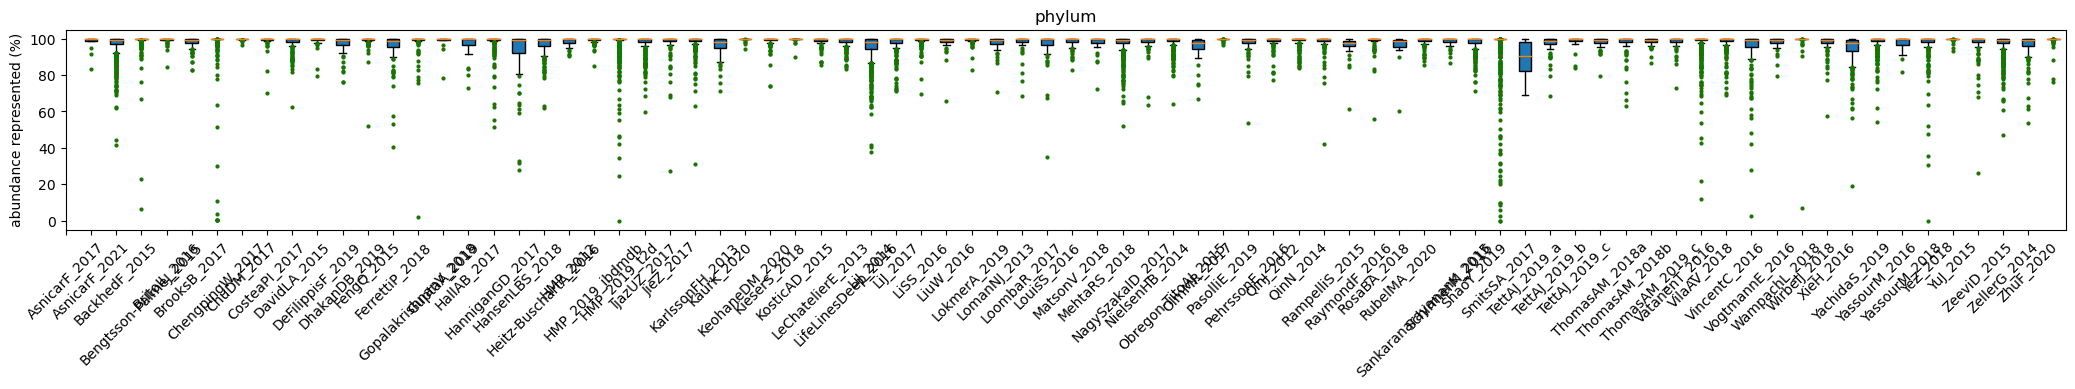

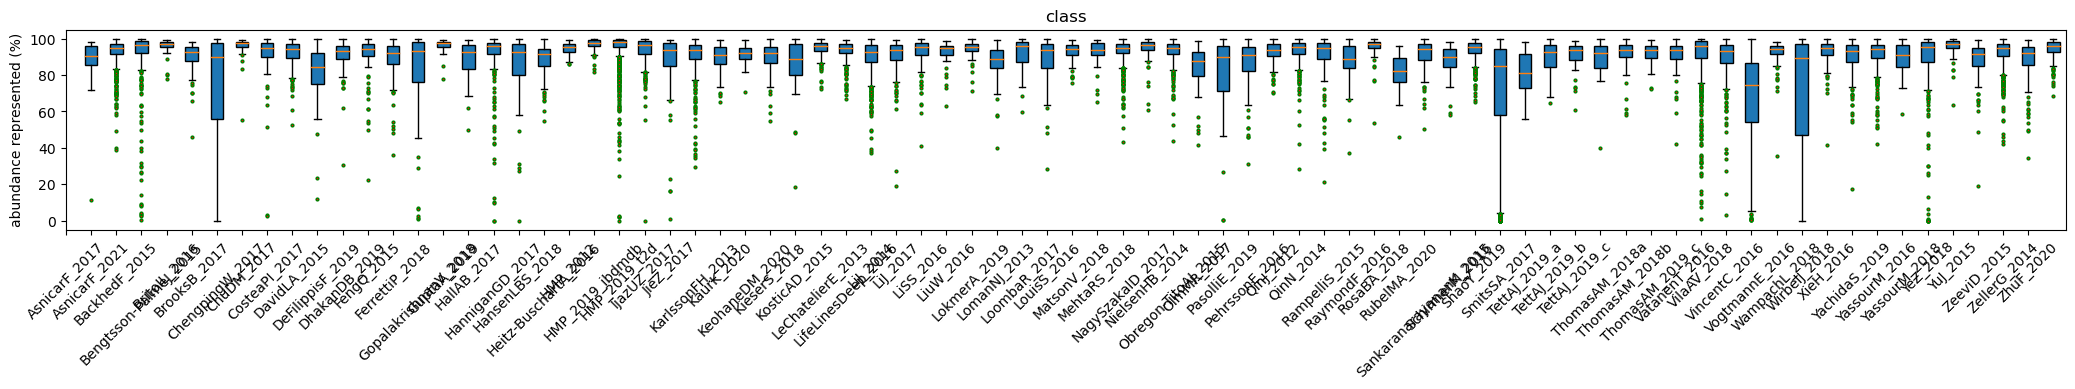

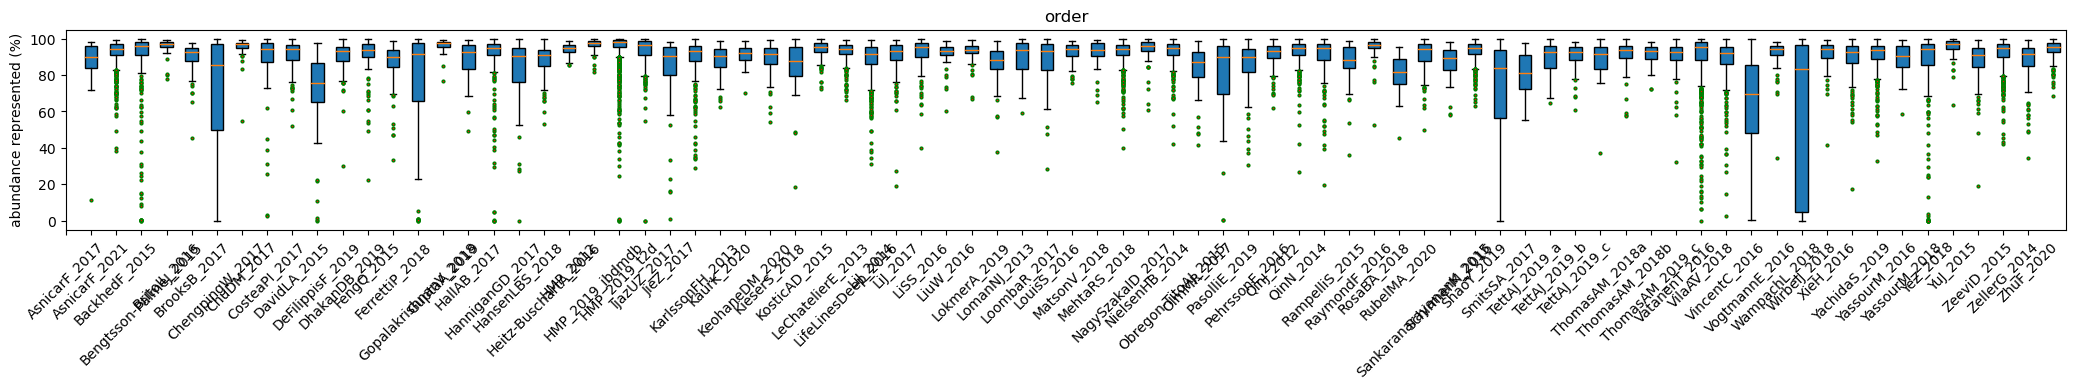

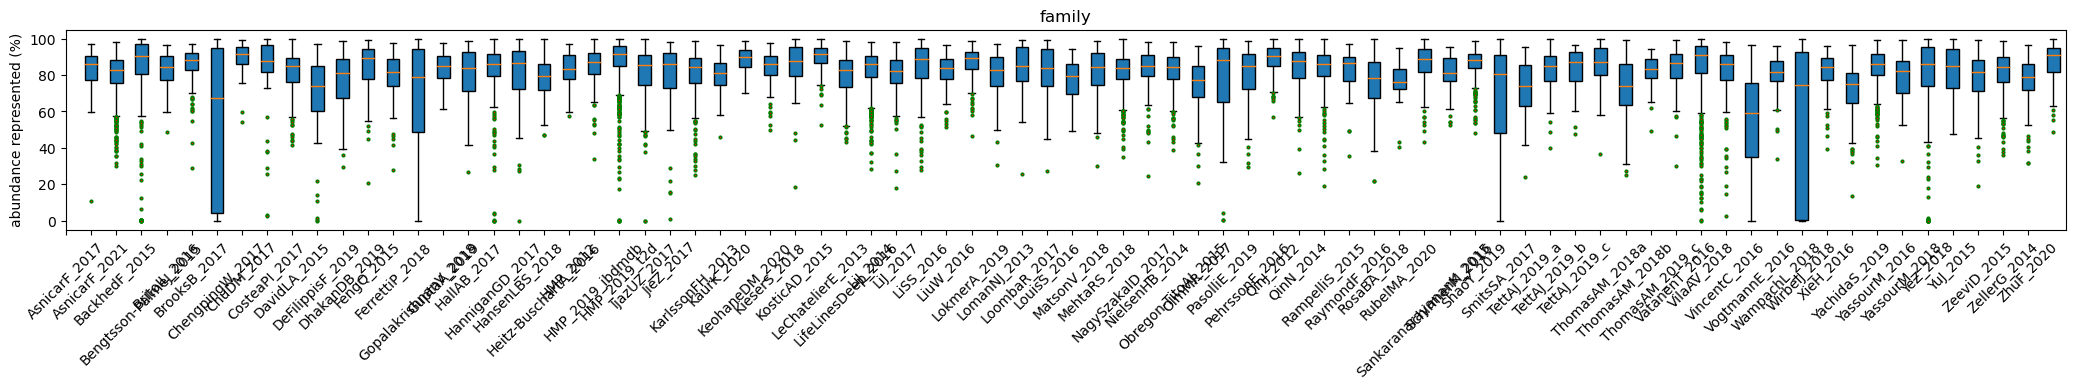

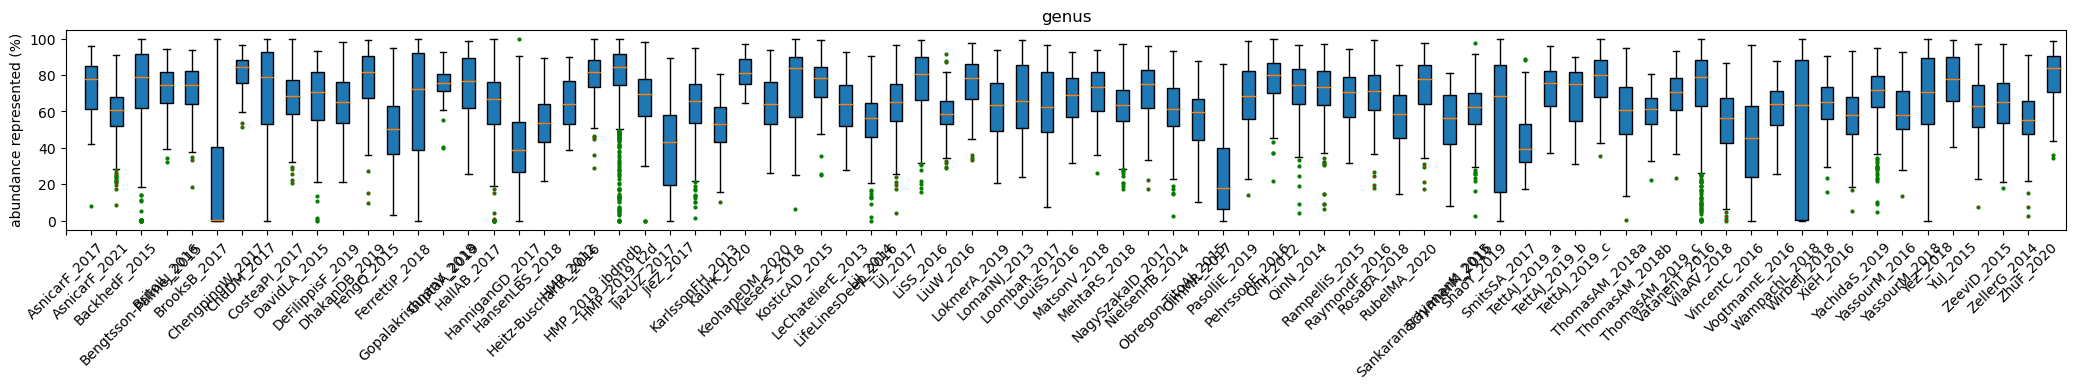

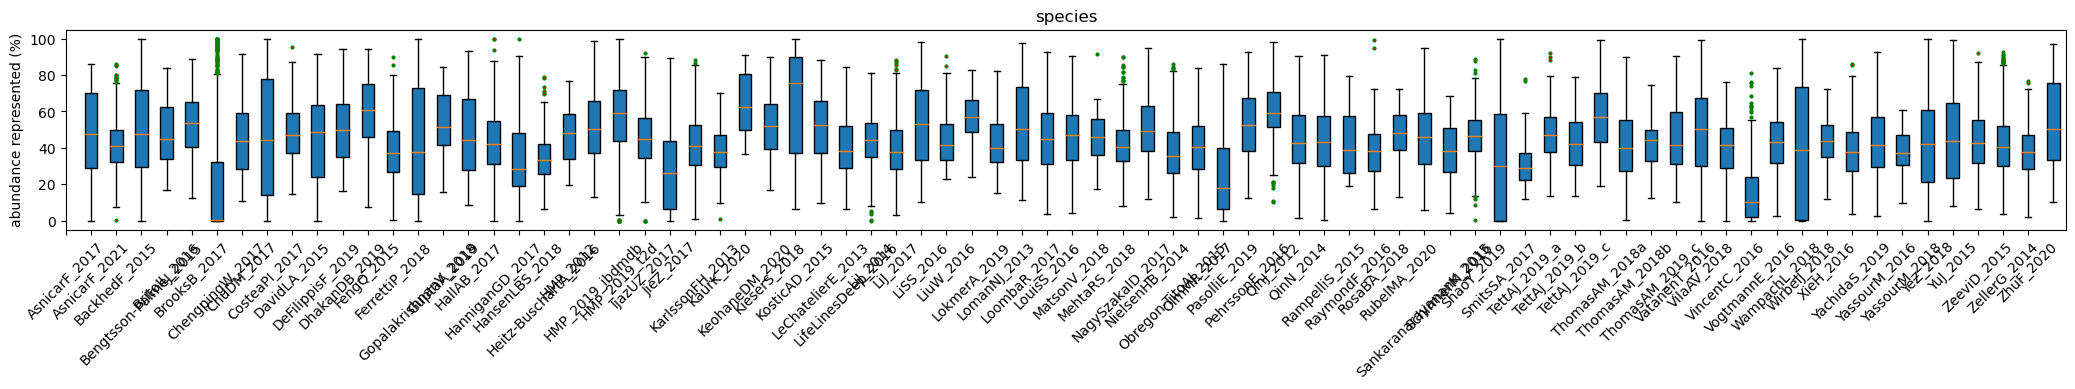

In [5]:
studylist=['AsnicarF_2017', 'AsnicarF_2021', 'BackhedF_2015',
       'Bengtsson-PalmeJ_2015', 'BritoIL_2016', 'BrooksB_2017',
       'ChengpingW_2017', 'ChuDM_2017', 'CosteaPI_2017', 'DavidLA_2015',
       'DeFilippisF_2019', 'DhakanDB_2019', 'FengQ_2015',
       'FerrettiP_2018', 'GopalakrishnanV_2018', 'GuptaA_2019',
       'HallAB_2017', 'HanniganGD_2017', 'HansenLBS_2018',
       'Heitz-BuschartA_2016', 'HMP_2012', 'HMP_2019_ibdmdb',
       'HMP_2019_t2d', 'IjazUZ_2017', 'JieZ_2017', 'KarlssonFH_2013',
       'KaurK_2020', 'KeohaneDM_2020', 'KieserS_2018', 'KosticAD_2015',
       'LeChatelierE_2013', 'LifeLinesDeep_2016', 'LiJ_2014', 'LiJ_2017',
       'LiSS_2016', 'LiuW_2016', 'LokmerA_2019', 'LomanNJ_2013',
       'LoombaR_2017', 'LouisS_2016', 'MatsonV_2018', 'MehtaRS_2018',
       'NagySzakalD_2017', 'NielsenHB_2014', 'Obregon-TitoAJ_2015',
       'OlmMR_2017', 'PasolliE_2019', 'PehrssonE_2016', 'QinJ_2012',
       'QinN_2014', 'RampelliS_2015', 'RaymondF_2016', 'RosaBA_2018',
       'RubelMA_2020', 'SankaranarayananK_2015', 'SchirmerM_2016',
       'ShaoY_2019', 'SmitsSA_2017', 'TettAJ_2019_a', 'TettAJ_2019_b',
       'TettAJ_2019_c', 'ThomasAM_2018a', 'ThomasAM_2018b',
       'ThomasAM_2019_c', 'VatanenT_2016', 'VilaAV_2018', 'VincentC_2016',
       'VogtmannE_2016', 'WampachL_2018', 'WirbelJ_2018', 'XieH_2016',
       'YachidaS_2019', 'YassourM_2016', 'YassourM_2018', 'YeZ_2018',
       'YuJ_2015', 'ZeeviD_2015', 'ZellerG_2014', 'ZhuF_2020']
lc=-1
for level in ["phylum","class","order","family","genus","species"]:
    lc=lc+1
    distribution_AsnicarF=[]
    for study in studylist:
        #select certain study
        select_samples=colnames.loc[colnames["study_name"]==study]

        #

        #display(select_samples)
        sample_names=select_samples["sample"].tolist()
        #display(len(sample_names))
        
        #go through levels and get distribution
        curdis=abundance_by_represented_taxonomiclevel_sum[lc].loc[sample_names].tolist()
        distribution_AsnicarF.append(curdis)
        
       
    # Create a figure instance
    fig = plt.figure(figsize=(20,2))
        
        # Create an axes instance
    ax = fig.add_axes([0,0,1,1])
    
    # Create the boxplot

    flierprops = dict(marker='o', markerfacecolor='r', markersize=2,
                  linestyle='none', markeredgecolor='g')



    bp2 = ax.boxplot(distribution_AsnicarF,widths=0.5,patch_artist=True,flierprops=flierprops)
    ax.set_title(level)
    ax.set_ylabel("abundance represented (%)")
    ax.set_xticks(range(len(studylist)))
    ax.set_xticklabels(studylist,rotation=45)
    plt.show()


In [6]:
# Plot distribution of covered abundance

,sample,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age,infant_age,age_category,...,hla_drb11,birth_order,age_twins_started_to_live_apart,zigosity,brinkman_index,alcohol_numeric,breastfeeding_duration,formula_first_day,ALT,eGFR
3964,CSM5FZ3N_P,HMP_2019_ibdmdb,C3001,stool,no,IBD,IBD,43.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3965,CSM5FZ3R_P,HMP_2019_ibdmdb,C3001,stool,no,IBD,IBD,43.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3966,CSM5YRY7_P,HMP_2019_ibdmdb,C3001,stool,no,IBD,IBD,43.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3967,CSM5FZ3V_P,HMP_2019_ibdmdb,C3001,stool,no,IBD,IBD,43.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3968,CSM5FZ4C_P,HMP_2019_ibdmdb,C3001,stool,no,IBD,IBD,43.0,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5586,PSMA26A1,HMP_2019_ibdmdb,P6038,stool,no,IBD,IBD,16.0,NaN,schoolage,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5587,PSMA26A3,HMP_2019_ibdmdb,P6038,stool,no,IBD,IBD,16.0,NaN,schoolage,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5588,PSMB4MC1,HMP_2019_ibdmdb,P6038,stool,no,IBD,IBD,16.0,NaN,schoolage,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5589,PSMB4MC3,HMP_2019_ibdmdb,P6038,stool,no,IBD,IBD,16.0,NaN,schoolage,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array(['IBD', 'healthy'], dtype=object)

(426, 130)

(1201, 130)

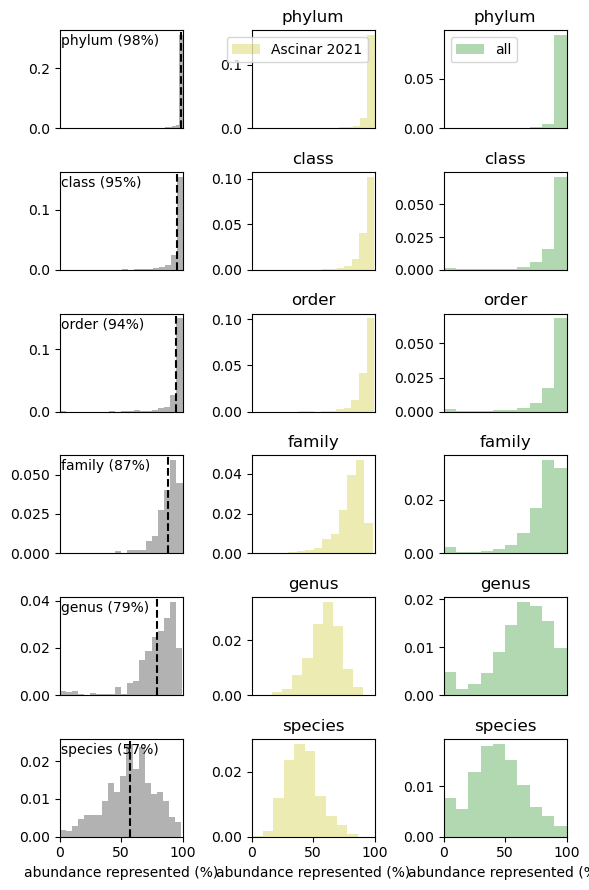

In [34]:
hmp=colnames.loc[colnames["study_name"]=="HMP_2019_ibdmdb"]
display(hmp)
display(hmp["disease"].unique())


sample_names_all=colnames["sample"].tolist()
#display(select_samples)

hmp_all=colnames.loc[(colnames["study_name"]=="HMP_2019_ibdmdb")]
sample_names_hmp_all=hmp_all["sample"].tolist()
hmp_healthy=colnames.loc[(colnames["study_name"]=="HMP_2019_ibdmdb") & (colnames["disease"]=="healthy")]
sample_names_hmp_healthy=hmp_healthy["sample"].tolist()
hmp_IBD=colnames.loc[(colnames["study_name"]=="HMP_2019_ibdmdb") & (colnames["disease"]=="IBD")]
sample_names_hmp_IBD=hmp_IBD["sample"].tolist()

display(hmp_healthy.shape)
display(hmp_IBD.shape)
ascinar2021=colnames.loc[colnames["study_name"]=="AsnicarF_2021"]
sample_names_ascinar2021=ascinar2021["sample"].tolist()

#prepare plots
fig, ax=plt.subplots(len(levels),3,figsize=(2*3,1.5*len(levels)))

#go through levels and get distribution
lc=-1
for level in levels:
        lc=lc+1

        #healthy
        curdis=abundance_by_represented_taxonomiclevel_sum[lc].loc[sample_names_hmp_healthy].tolist()
        ax[lc,0].hist(curdis,color='k',alpha=0.3,label="hmp healthy",density=True,bins=20)
        ax[lc,0].axvline(mean(curdis),color='k',ls='--')
        ax[lc,0].text(.01, .96, level+" ("+str(int(mean(curdis)))+"%)", ha='left', va='top', transform=ax[lc,0].transAxes,fontsize=10)

        #curdis=abundance_by_represented_taxonomiclevel_sum[lc].loc[sample_names_hmp_IBD].tolist()
        #ax[lc,0].hist(curdis,color='b',alpha=0.3,label="hmp IBD",density=True)

        curdis=abundance_by_represented_taxonomiclevel_sum[lc].loc[sample_names_ascinar2021].tolist()
        ax[lc,1].hist(curdis,color='y',alpha=0.3,label="Ascinar 2021",density=True)

        curdis=abundance_by_represented_taxonomiclevel_sum[lc].loc[sample_names_all].tolist()
        ax[lc,2].hist(curdis,color='g',alpha=0.3,label="all",density=True)

        # Create the boxplot
        #bp = ax.violinplot(distribution_AsnicarF,positions=np.array(range(1,7))*2)
        #bp2 = ax.violinplot(distribution_All,positions=np.array(range(1,7))*2+0.7,widths=0.5)
        
        
        #ax.set_xticks(np.array(range(1,7))*2)

        if lc==0:
            #ax[lc,0].legend()
            ax[lc,1].legend()
            ax[lc,2].legend()
        if lc<5:
            ax[lc,0].set_xticks([])
            ax[lc,1].set_xticks([])
            ax[lc,2].set_xticks([])
        else:
            ax[lc,0].set_xlabel("abundance represented (%)")
            ax[lc,1].set_xlabel("abundance represented (%)")
            ax[lc,2].set_xlabel("abundance represented (%)")
            
        
        #ax[lc,0].set_title(level)#["phylum","class","order","family","genus","species"])
        ax[lc,1].set_title(level)#["phylum","class","order","family","genus","species"])
        ax[lc,2].set_title(level)#["phylum","class","order","family","genus","species"])

        ax[lc,0].set_xlim(0,100)
        ax[lc,1].set_xlim(0,100)
        ax[lc,2].set_xlim(0,100)
    #plt.show()
fig.tight_layout()
fig.savefig("plot_output_figure1/abundance_distribution.pdf")
